<a href="https://colab.research.google.com/github/ManishManda/ImageClassificationUsingvgg16/blob/main/ImageClassificationCelebADataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"russelpears","key":"f202800ab76110e2789ec3d042b078c2"}'}

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.32G/1.33G [00:09<00:00, 176MB/s]
100% 1.33G/1.33G [00:09<00:00, 153MB/s]


In [ ]:
# unzip the dataset to the current directory and remove the zip file
!unzip celeba-dataset.zip -d celeba-dataset && rm celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: celeba-dataset/img_align_celeba/img_

In [ ]:
import pandas as pd
anno = pd.read_csv('celeba-dataset/list_attr_celeba.csv')
anno.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
# Importing needed libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import warnings
import cv2
import random
import tensorflow as tf

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
anno = anno[['image_id', 'Male']] # this is for R1

In [ ]:
partition = pd.read_csv('celeba-dataset/list_eval_partition.csv')

In [ ]:
df = pd.merge(anno, partition, on='image_id', how='inner')

In [ ]:
train_df = df[df['partition'] == 0]
test_df = df[df['partition'] == 1]
val_df = df[df['partition'] == 2]

In [ ]:
train_df = train_df.sample(frac=0.1, random_state=42)
train_df.head()
val_df = val_df.sample(frac=0.1, random_state=42)
val_df.head()
test_df = test_df.sample(frac=0.1, random_state=42)
print(test_df.head())

          image_id  Male  partition
171444  171445.jpg     1          1
176301  176302.jpg     1          1
166355  166356.jpg    -1          1
169233  169234.jpg    -1          1
165315  165316.jpg    -1          1


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, batch_size=32, dim=(64,64), n_channels=3, n_classes=1, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # saves memory by batching
        df_temp = self.df.iloc[indexes]
        X, y = self.__data_generation(df_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, df_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)
        for i, row in enumerate(df_temp.values):
            img = image.load_img('celeba-dataset/img_align_celeba/img_align_celeba/' + row[0]) # extract image
            # normally images would need to be cropped at this point, but in this case there is no need
            # as we are using the aligned and cropped version.
            img = img.resize(self.dim)
            img = image.img_to_array(img) # this are the image pixels flattened into an array

            #normalize the resized images
            img /= 255.0
            X[i,] = img
            # this is the set of normalized pixel values captured into a 2D array for sample in the batch

            #specify the multiple targets now into your y vector
            y[i,] = row[1:2] # there are two targets for R1
        return X, y

In [ ]:
# using vgg16 as feature extractor - this is a simpler, but equally eefective
vgg16 = tf.keras.applications.VGG16(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
vgg16.trainable = False

In [ ]:
# creating the model
model = tf.keras.Sequential([
    vgg16,
    # flatten the top 15 layers into one single layer containing the weights learned
    # in the first 15 layers of vgg16
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(512, activation='relu'),  # add a dense layer for specification
tf.keras.layers.Dense(2, activation='sigmoid'),
# the number needs to match with the number of targets, which for R1 is 2.
])

In [ ]:
# compiling the model
model.compile(optimizer=SGD(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# creating the train, test and validation data generators
train_generator = DataGenerator(train_df, batch_size=32, dim=(64,64), n_channels=3, n_classes=1, shuffle=True)
test_generator = DataGenerator(test_df, batch_size=32, dim=(64,64), n_channels=3, n_classes=1, shuffle=True)
val_generator = DataGenerator(val_df, batch_size=32, dim=(64,64), n_channels=3, n_classes=1, shuffle=True)

In [ ]:
history = model.fit_generator(train_generator, epochs=1, validation_data=val_generator)

508/508 [==============================] - 929s 2s/step - loss: -0.4523 - accuracy: 0.4146 - val_loss: -1.3910 - val_accuracy: 0.1255


In [ ]:
print(history.history)

{'loss': [-0.4523281753063202], 'accuracy': [0.4146161377429962], 'val_loss': [-1.390954613685608], 'val_accuracy': [0.1255040317773819]}


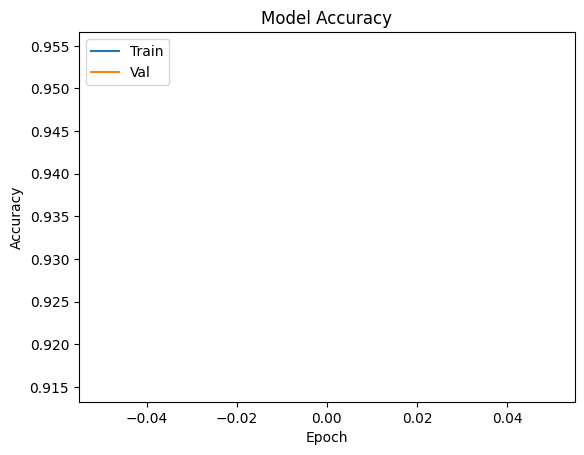

In [ ]:
# plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
evaluation=model.evaluate(x=test_generator)

62/62 [==============================] - 96s 2s/step - loss: -0.8988 - accuracy: 0.7671


In [ ]:
prediction = model.predict(x=test_generator)
print(prediction)
(prediction > 0.5).astype(int)

62/62 [==============================] - 98s 2s/step
[[0.00751908 0.01026397]
 [0.01198157 0.01209734]
 [0.00446616 0.00744783]
 ...
 [0.0062464  0.00910732]
 [0.00295366 0.00387223]
 [0.01042172 0.01672092]]


array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

In [ ]:
print(test_df)

          image_id  Male  partition
171444  171445.jpg     1          1
176301  176302.jpg     1          1
166355  166356.jpg    -1          1
169233  169234.jpg    -1          1
165315  165316.jpg    -1          1
...            ...   ...        ...
174735  174736.jpg    -1          1
162909  162910.jpg    -1          1
165582  165583.jpg    -1          1
170687  170688.jpg    -1          1
171455  171456.jpg     1          1

[1987 rows x 3 columns]


# **R2**

In [ ]:
anno = pd.read_csv('celeba-dataset/list_attr_celeba.csv')
anno.head()

In [ ]:
anno = anno[['image_id', 'Male', 'Arched_Eyebrows']] # this is for R1
anno.head(10)

In [ ]:
df_2 = pd.merge(anno, partition, on='image_id', how='outer')
df_2.head()

In [ ]:
# using vgg16 as feature extractor - this is a simpler, but equally eefective
vgg16 = tf.keras.applications.VGG16(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
#above line specifies that we are freezing the weights for all layers except for the top 2 layers
vgg16.trainable = False

In [ ]:
# creating the model
model = tf.keras.Sequential([
    vgg16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),# add a dense layer for specification
    tf.keras.layers.Dense(2, activation='sigmoid') # now specify the number of neurons in the output layer with the appropriate number of output neurons
    # the number needs to match with the number of targets, which for R1 is 2.
])

In [ ]:
model.compile(optimizer=SGD(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
train_df_2 = df_2[df_2['partition'] == 0]
test_df_2 = df_2[df_2['partition'] == 1]
val_df_2 = df_2[df_2['partition'] == 2]

In [ ]:
# randomly select a fraction of images from the train dataframe
train_df_2 = train_df_2.sample(frac=0.1, random_state=42)
train_df_2.head()

# similarly select a fraction of images from the validation dataframe
val_df_2 = val_df_2.sample(frac=0.1, random_state=42)
val_df_2.head()

In [ ]:
# creating the train, test and validation data generators
train_generator_2 = DataGenerator(train_df_2, batch_size=32, dim=(64,64), n_channels=3, n_classes=2, shuffle=True)
test_generator_2 = DataGenerator(test_df_2, batch_size=32, dim=(64,64), n_channels=3, n_classes=2, shuffle=True)
val_generator_2 = DataGenerator(val_df_2, batch_size=32, dim=(64,64), n_channels=3, n_classes=2, shuffle=True)

In [ ]:
history_2 = model.fit(train_generator_2, epochs=5, validation_data=val_generator_2)

In [ ]:
# plotting the training and validation accuracy
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### **R3**

In [ ]:
land_mark = pd.read_csv('/content/celeba-dataset/list_landmarks_align_celeba.csv')
land_mark.head()

In [ ]:
import pandas as pd
anno = pd.read_csv('celeba-dataset/list_attr_celeba.csv')
anno.head()

In [ ]:
partition = pd.read_csv('celeba-dataset/list_eval_partition.csv')
partition.head()

In [ ]:
df_3 = pd.merge(land_mark,anno, on='image_id', how='outer')

df_3.head()

df_3['eye_width'] = df_3['righteye_x'] - df_3['lefteye_x']

max_eye_width = df_3['eye_width'].max()
min_eye_width = df_3['eye_width'].min()

df_3['normalized_eye_width'] = (df_3['eye_width'] - min_eye_width) / (max_eye_width - min_eye_width)

df_3['quantized_eye_width'] = pd.qcut(df_3['normalized_eye_width'], q=4, labels=False)+1

df_3=df_3[['image_id','Male','quantized_eye_width']]


df_3=pd.merge(df_3,partition,on='image_id',how='outer')
train_df_3 = df_3[df_3['partition'] == 0]
test_df_3 = df_3[df_3['partition'] == 1]
val_df_3= df_3[df_3['partition'] == 2]

print(train_df_3.shape)


NameError: name 'land_mark' is not defined

In [ ]:
# randomly select a fraction of images from the train dataframe
train_df_3 = train_df_3.sample(frac=0.1, random_state=42)


# similarly select a fraction of images from the validation dataframe
val_df_3 = val_df_3.sample(frac=0.1, random_state=42)
# val_df_3.head()
print(train_df_3.shape)


NameError: name 'train_df_3' is not defined

In [ ]:


class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, batch_size=32, dim=(64,64), n_channels=3, n_classes=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # saves memory by batching
        df_temp = self.df.iloc[indexes]
        X, y = self.__data_generation(df_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, df_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)
        for i, row in enumerate(df_temp.values):
            img = image.load_img('celeba-dataset/img_align_celeba/img_align_celeba/' + row[0]) # extract image
            # normally images would need to be cropped at this point, but in this case there is no need
            # as we are using the aligned and cropped version.
            img = img.resize(self.dim)
            img = image.img_to_array(img) # this are the image pixels flattened into an array

            #normalize the resized images
            X[i,] = img / 255.0 # this is the set of normalized pixel values captured into a 2D array for sample in the batch

            #specify the multiple targets now into your y vector
            y[i,] = row[1:3] # there are two targets for R1

        return X, y

In [ ]:
# using vgg16 as feature extractor - this is a simpler, but equally eefective
vgg16 = tf.keras.applications.VGG16(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
#above line specifies that we are freezing the weights for all layers except for the top 2 layers
vgg16.trainable = False

In [ ]:
# creating the model
model_3 = tf.keras.Sequential([
    vgg16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),# add a dense layer for specification
    tf.keras.layers.Dense(2, activation='softmax') # now specify the number of neurons in the output layer with the appropriate number of output neurons
    # the number needs to match with the number of targets, which for R1 is 2.
])


In [ ]:
model_3.compile(optimizer=SGD(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# creating the train, test and validation data generators
train_generator_3 = DataGenerator(train_df_3, batch_size=32, dim=(64,64), n_channels=3, n_classes=2, shuffle=True)
test_generator_3 = DataGenerator(test_df_3, batch_size=32, dim=(64,64), n_channels=3, n_classes=2, shuffle=True)
val_generator_3= DataGenerator(val_df_3, batch_size=32, dim=(64,64), n_channels=3, n_classes=2, shuffle=True)

NameError: name 'train_df_3' is not defined

In [ ]:
for batch_X, batch_y in test_generator_3:
    print("Batch X shape:", batch_X.shape)
    print("Batch y shape:", batch_y.shape)
    print("Batch X values:")
    print(batch_X)
    print("Batch y values:")
    print(batch_y)
    break  # breaking after the first batch to avoid printing the entire dataset


In [ ]:
history_3 = model_3.fit(train_generator_3, epochs=5, validation_data=val_generator_3)


In [ ]:
data=model_3.predict(test_generator_3)
print(data)

## **R4**

In [ ]:
import pandas as pd
land_mark = pd.read_csv('/content/celeba-dataset/list_landmarks_align_celeba.csv')
land_mark.head()

In [ ]:
import pandas as pd
anno_2 = pd.read_csv('celeba-dataset/list_attr_celeba.csv')

In [ ]:
partition = pd.read_csv('celeba-dataset/list_eval_partition.csv')
partition.head()

In [ ]:
# Compute mouth width index
land_mark['mouth_width'] = land_mark['rightmouth_x'] - land_mark['leftmouth_x']

# Normalize mouth width index to range [0, 1]
min_mouth_width = land_mark['mouth_width'].min()
max_mouth_width = land_mark['mouth_width'].max()
land_mark['normalized_mouth_width'] = (land_mark['mouth_width'] - min_mouth_width) / (max_mouth_width - min_mouth_width)

# Quantize mouth width index into 4 quartiles
land_mark['mouth_width_quartile'] = pd.qcut(land_mark['normalized_mouth_width'], q=4, labels=False)

# Output the DataFrame with mouth width quartiles
print(land_mark[['mouth_width', 'normalized_mouth_width', 'mouth_width_quartile']])


In [ ]:
df_4 = pd.merge(land_mark,anno, on='image_id', how='outer')

In [ ]:
df_4=pd.merge(df_4,partition,on='image_id',how='outer')
df_4=df_4[['image_id','Smiling','mouth_width_quartile','partition']]
df_4.head()

In [ ]:

train_df_4 = df_4[df_4['partition'] == 0]
test_df_4 = df_4[df_4['partition'] == 1]
val_df_4= df_4[df_4['partition'] == 2]
df_4.head()
# randomly select a fraction of images from the train dataframe
train_df_4 = train_df_4.sample(frac=0.1, random_state=42)
train_df_4.head()

# similarly select a fraction of images from the validation dataframe
val_df_4 = val_df_4.sample(frac=0.1, random_state=42)
val_df_4.head()

In [ ]:
# Data generator class - this is a key class that is used to batch the data so as to
# reduce compute time as well as to fit training segments into available memory
# Additionally it allows you to specify multiple targets for classification
# Also allows for image cropping

class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, batch_size=32, dim=(64,64), n_channels=3, n_classes=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # saves memory by batching
        df_temp = self.df.iloc[indexes]
        X, y = self.__data_generation(df_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, df_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)
        for i, row in enumerate(df_temp.values):
            img = image.load_img('celeba-dataset/img_align_celeba/img_align_celeba/' + row[0]) # extract image
            # normally images would need to be cropped at this point, but in this case there is no need
            # as we are using the aligned and cropped version.
            img = img.resize(self.dim)
            img = image.img_to_array(img) # this are the image pixels flattened into an array

            #normalize the resized images
            X[i,] = img / 255.0 # this is the set of normalized pixel values captured into a 2D array for sample in the batch

            #specify the multiple targets now into your y vector
            y[i,] = row[1:3] # there are two targets for R1

        return X, y

In [ ]:
# using vgg16 as feature extractor - this is a simpler, but equally eefective
vgg16 = tf.keras.applications.VGG16(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
#above line specifies that we are freezing the weights for all layers except for the top 2 layers
vgg16.trainable = False

In [ ]:
# creating the model
model_4 = tf.keras.Sequential([
    vgg16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),# add a dense layer for specification
    tf.keras.layers.Dense(2, activation='softmax') # now specify the number of neurons in the output layer with the appropriate number of output neurons
    # the number needs to match with the number of targets, which for R1 is 2.
])


In [ ]:
model_4.compile(optimizer=SGD(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# creating the train, test and validation data generators
train_generator_4 = DataGenerator(train_df_4, batch_size=32, dim=(64,64), n_channels=3, n_classes=2, shuffle=True)
test_generator_4 = DataGenerator(test_df_4, batch_size=32, dim=(64,64), n_channels=3, n_classes=2, shuffle=True)
val_generator_4= DataGenerator(val_df_4, batch_size=32, dim=(64,64), n_channels=3, n_classes=2, shuffle=True)

In [ ]:
history_4 = model_4.fit(train_generator_4, epochs=5, validation_data=val_generator_4)

In [ ]:
predictions=model_4.predict(test_generator_4)